**Fine Tuned ResNet**

Designs a deep learning model specialized in recognizing Leonardo DiCaprio’s face. Our model utilizes MTCNN (Multi-task Cascaded Convolutional Networks) to detect and crop faces from our dataset of images. Then, we integrate our model on a fine-tuned version of Inception ResNet V1, adjusted using an 80/20 train validation split, to align with the specific characteristics of DiCaprio's features.

In [ ]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.7 MB/s eta 0:00:00


In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os
import time

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<strong> Define run parameters </strong>

In [ ]:
# This path should direct to leonardo_dataset where the folder structure should look like the following
# leonardo_dataset
#  |  leonardo
#  |  not_leonardo
data_dir = '/content/drive/MyDrive/581 Final Project/Code Workspace/images/leonardo_dataset'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

# Determine if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


<strong> Define a collate function </strong>

In [ ]:
# Defines a collate_pil function that takes a list of tuples, extracts and
# collates the first elements into one list (out_x) and the second elements
# into another list (out_y), and returns a tuple containing both lists.

def collate_pil(x):
    out_x, out_y = [], []
    for xx, yy in x:
        out_x.append(xx)
        out_y.append(yy)
    return out_x, out_y

<strong> Define a batch timer </strong>

In [ ]:
class BatchTimer(object):
    """Batch timing class.
    Use this class for tracking training and testing time/rate per batch or per sample.

    Keyword Arguments:
        rate {bool} -- Whether to report a rate (batches or samples per second) or a time (seconds
            per batch or sample). (default: {True})
        per_sample {bool} -- Whether to report times or rates per sample or per batch.
            (default: {True})
    """

    def __init__(self, rate=True, per_sample=True):
        self.start = time.time()
        self.end = None
        self.rate = rate
        self.per_sample = per_sample

    def __call__(self, y_pred, y):
        self.end = time.time()
        elapsed = self.end - self.start
        self.start = self.end
        self.end = None

        if self.per_sample:
            elapsed /= len(y_pred)
        if self.rate:
            elapsed = 1 / elapsed

        return torch.tensor(elapsed)

<strong> Define a logger </strong>

In [ ]:
class Logger(object):
    """
    Logger class.
    Real-time logging of training or validation progress, printing iteration
    details, and updating dynamically until the process completes
    """
    def __init__(self, mode, length, calculate_mean=False):
        self.mode = mode
        self.length = length
        self.calculate_mean = calculate_mean
        if self.calculate_mean:
            self.fn = lambda x, i: x / (i + 1)
        else:
            self.fn = lambda x, i: x

    def __call__(self, loss, metrics, i):
        track_str = '\r{} | {:5d}/{:<5d}| '.format(self.mode, i + 1, self.length)
        loss_str = 'loss: {:9.4f} | '.format(self.fn(loss, i))
        metric_str = ' | '.join('{}: {:9.4f}'.format(k, self.fn(v, i)) for k, v in metrics.items())
        print(track_str + loss_str + metric_str + '   ', end='')
        if i + 1 == self.length:
            print('')

<strong> Define a pass_epoch function </strong>

In [ ]:
# Training or validating a PyTorch model over data loader, calculating
# loss and specified metrics, performing optimization steps if in training
# mode, updating a dynamic logger with real-time progress information, and
# optionally logging metrics using a writer.

def pass_epoch(
    model, loss_fn, loader, optimizer=None, scheduler=None,
    batch_metrics={'time': BatchTimer()}, show_running=True,
    device='cpu', writer=None
):
    mode = 'Train' if model.training else 'Valid'
    logger = Logger(mode, length=len(loader), calculate_mean=show_running)
    loss = 0
    metrics = {}

    for i_batch, (x, y) in enumerate(loader):
        x = torch.stack(x, dim=0)
        y = torch.tensor(y)
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss_batch = loss_fn(y_pred, y)

        if model.training:
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

        metrics_batch = {}
        for metric_name, metric_fn in batch_metrics.items():
            metrics_batch[metric_name] = metric_fn(y_pred, y).detach().cpu()
            metrics[metric_name] = metrics.get(metric_name, 0) + metrics_batch[metric_name]

        if writer is not None and model.training:
            if writer.iteration % writer.interval == 0:
                writer.add_scalars('loss', {mode: loss_batch.detach().cpu()}, writer.iteration)
                for metric_name, metric_batch in metrics_batch.items():
                    writer.add_scalars(metric_name, {mode: metric_batch}, writer.iteration)
            writer.iteration += 1

        loss_batch = loss_batch.detach().cpu()
        loss += loss_batch
        if show_running:
            logger(loss, metrics, i_batch)
        else:
            logger(loss_batch, metrics_batch, i_batch)

    if model.training and scheduler is not None:
        scheduler.step()

    loss = loss / (i_batch + 1)
    metrics = {k: v / (i_batch + 1) for k, v in metrics.items()}

    if writer is not None and not model.training:
        writer.add_scalars('loss', {mode: loss.detach()}, writer.iteration)
        for metric_name, metric in metrics.items():
            writer.add_scalars(metric_name, {mode: metric})

    return loss, metrics

<strong> Define a dataloader </strong>

In [ ]:
# Dataloader from data_dir along with a transform

dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]

loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=collate_pil
)

[('/content/drive/MyDrive/581 Final Project/Code Workspace/images/leonardo_dataset/leonardo/leo_0.jpg', 0), ('/content/drive/MyDrive/581 Final Project/Code Workspace/images/leonardo_dataset/leonardo/leo_1.jpg', 0), ('/content/drive/MyDrive/581 Final Project/Code Workspace/images/leonardo_dataset/leonardo/leo_10.jpg', 0), ('/content/drive/MyDrive/581 Final Project/Code Workspace/images/leonardo_dataset/leonardo/leo_100.jpg', 0), ('/content/drive/MyDrive/581 Final Project/Code Workspace/images/leonardo_dataset/leonardo/leo_1002.jpg', 0), ('/content/drive/MyDrive/581 Final Project/Code Workspace/images/leonardo_dataset/leonardo/leo_1003.jpg', 0), ('/content/drive/MyDrive/581 Final Project/Code Workspace/images/leonardo_dataset/leonardo/leo_1004.jpg', 0), ('/content/drive/MyDrive/581 Final Project/Code Workspace/images/leonardo_dataset/leonardo/leo_1005.jpg', 0), ('/content/drive/MyDrive/581 Final Project/Code Workspace/images/leonardo_dataset/leonardo/leo_1009.jpg', 0), ('/content/drive/M

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<strong> MTCNN module </strong>
<br />
<br />
The following gets the faces through MTCNN. Unless we do not have the cropped faces already in the dataset, this is not be needed for our fine tuning since we already have the cropped faces.

In [ ]:
# Iterate through the DataLoader object and obtain cropped faces.
# if we need to recrop images, set this to True

recrop = False
if recrop:
  mtcnn = MTCNN(
      image_size=160, margin=0, min_face_size=20,
      thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
      device=device
  )

  for i, (x, y) in enumerate(loader):
      mtcnn(x, save_path=y)
      print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')

  # Remove mtcnn to reduce GPU memory usage
  del mtcnn

<strong> Resnet module </strong>

In [ ]:
# Define Inception Resnet V1 module

resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
# Display the layers

for name, module in resnet.named_modules():
  print("Layer named: ", name)
  print(module)
  print()

Layer named:  
InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )


<strong> Fine Tuning the Model </strong>

In [ ]:
# Freeze all layers

for param in resnet.parameters():
    param.requires_grad = False

# Unfreeze last_linear, last_bn and logits
unfreeze_layers = ['last_linear', 'last_bn', 'logits']
for name, param in resnet.named_parameters():
    if any(layer_name in name for layer_name in unfreeze_layers):
        param.requires_grad = True

# Move the modified model to the device
resnet = resnet.to(device)

<strong> Optimizer, scheduler, dataset, dataloader </strong>

In [ ]:
# Define optimizer, scheduler, dataset, and dataloader
# 0.0001 performs at 96% but slightly overfits

optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
scheduler = MultiStepLR(optimizer, [5, 10])

# Use transforms to reduce overfitting
trans = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
])

# usingCropped defines whether we are using the cropped images from MTCNN
usingCropped = True
if usingCropped:
  dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
else:
  dataset = datasets.ImageFolder(data_dir, transform=trans)

# Get random indices for train and validation sets
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

# Define dataloaders for train and validation
train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=collate_pil,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=collate_pil,
    sampler=SubsetRandomSampler(val_inds)
)

# Define loss and evaluation functions
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

# Writer
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<strong> Visualize the dataset </strong>

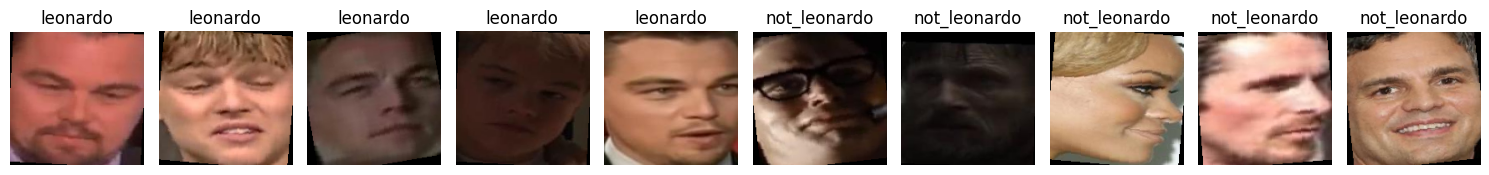

In [ ]:
# Showing 10 images, and their outputs as "Leo" or "Not Leo"

number_of_images = 10
fig, axes = plt.subplots(1, number_of_images, figsize=(15, 3))
j = 0
for i in range(0, len(dataset), len(dataset) // (number_of_images - 1)):
    img, label = dataset[i]
    class_label = dataset.classes[label]
    image_np = np.array(img)
    image_np = np.transpose(image_np, (1, 2, 0))

    axes[j].imshow(image_np)
    axes[j].set_title(f"{class_label}")
    axes[j].axis('off')
    j += 1

plt.tight_layout()
plt.show()

<strong> Training process! </strong>

In [ ]:
# This cell takes 30 minutes to run
# Keep track of metrics

epoch_losses_train = []
epoch_accuracies_train = []
epoch_losses_validation = []
epoch_accuracies_validation = []

print('\n\nInitial')
print('-' * 10)
resnet.eval()
initial_loss, initial_metrics = pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

initial_losses = [initial_loss.item()]
initial_accuracies = [initial_metrics['acc'].item()]

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    train_loss, train_metrics = pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )
    epoch_losses_train.append(train_loss.item())
    epoch_accuracies_train.append(train_metrics['acc'].item())

    resnet.eval()
    eval_loss, eval_metrics = pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )
    epoch_losses_validation.append(eval_loss.item())
    epoch_accuracies_validation.append(eval_metrics['acc'].item())

writer.close()



Initial
----------
Valid |    14/14   | loss:    0.6815 | fps:   18.7404 | acc:    0.6035   

Epoch 1/8
----------
Train |    54/54   | loss:    0.2148 | fps:   18.2089 | acc:    0.9259   
Valid |    14/14   | loss:    0.1351 | fps:   19.7656 | acc:    0.9420   

Epoch 2/8
----------
Train |    54/54   | loss:    0.1472 | fps:   18.0347 | acc:    0.9514   
Valid |    14/14   | loss:    0.1106 | fps:   19.7361 | acc:    0.9621   

Epoch 3/8
----------
Train |    54/54   | loss:    0.1442 | fps:   18.3613 | acc:    0.9463   
Valid |    14/14   | loss:    0.1143 | fps:   19.4508 | acc:    0.9509   

Epoch 4/8
----------
Train |    54/54   | loss:    0.1552 | fps:   18.3459 | acc:    0.9474   
Valid |    14/14   | loss:    0.1180 | fps:   18.9916 | acc:    0.9509   

Epoch 5/8
----------
Train |    54/54   | loss:    0.1342 | fps:   18.0516 | acc:    0.9584   
Valid |    14/14   | loss:    0.1126 | fps:   19.1397 | acc:    0.9576   

Epoch 6/8
----------
Train |    54/54   | loss:    0.1

<strong> Visualize Training Loss </strong>

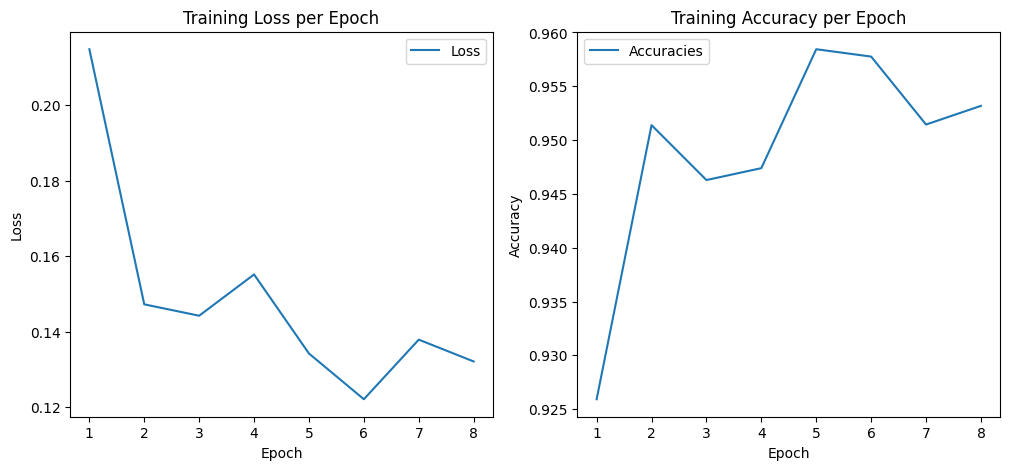

In [ ]:
plt.figure(figsize=(12, 5))
# Plot the first subplot
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(epoch_losses_train) + 1), epoch_losses_train, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

# Plot the second subplot
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(epoch_accuracies_train) + 1), epoch_accuracies_train, label='Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()

# Display the plots
plt.show()

<strong> Visualize Validation Loss </strong>

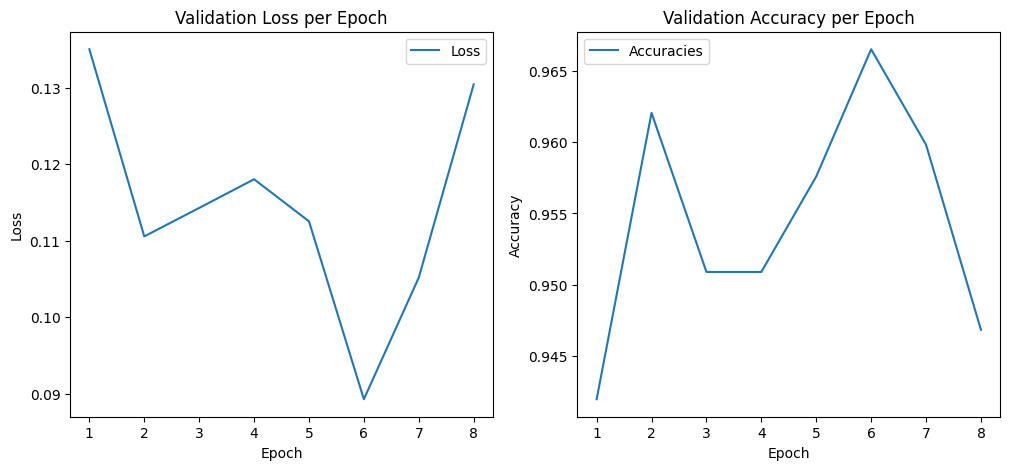

In [ ]:
plt.figure(figsize=(12, 5))
# Plot the first subplot
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(epoch_losses_validation) + 1), epoch_losses_validation, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()

# Plot the second subplot
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(epoch_accuracies_validation) + 1), epoch_accuracies_validation, label='Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()

# Display the plots
plt.show()

<strong> Saving model for streaming </strong>

In [ ]:
torch.save(resnet, "/content/drive/My Drive/581 Final Project/Code Workspace/face_recog_2.h5")

<strong> Model prediction example </strong>

In [ ]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 13.0 MB/s eta 0:00:00


In [ ]:
from mtcnn import MTCNN
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

In [ ]:
# Uses MTCNN (Multi-Task Cascaded Convolutional Networks) model to detect
# faces in a given frame

def faceDetection(frame):
    detector = MTCNN()
    boxes = detector.detect_faces(frame)
    if boxes:
        box = boxes[0]['box']
        conf = boxes[0]['confidence']
        if conf > 0.9:
            x, y, w, h = box[0], box[1], box[2], box[3]
            return x, y, w, h
    else:
        return None

1/1 [==============================] - 0s 148ms/step
leo probability: 0.0359731949865818
not leo probability: 0.8665320873260498
1/1 [==============================] - 0s 120ms/step
leo probability: 0.20038054883480072
not leo probability: 0.4166484475135803
1/1 [==============================] - 0s 107ms/step
leo probability: 0.13940560817718506
not leo probability: 0.7894493937492371


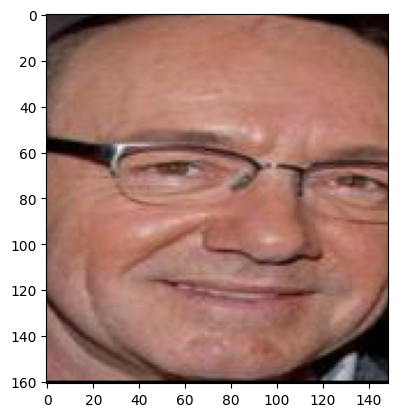

In [ ]:
# Image Prediction
predict_image_dir = "./drive/MyDrive/581 Final Project/Code Workspace/images/leonardo_dataset_cropped/not_leonardo/"

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])

resnet.eval()

for image_path in os.listdir(predict_image_dir)[:3]:
  img = Image.open(predict_image_dir + image_path)
  frame = np.array(img.convert('RGB'), 'f')
  detected_faces = faceDetection(frame)
  if detected_faces != None:
    x, y, w, h = detected_faces
    cropped_face = img.crop([x, y, x + w, y + h])
    input_tensor = transform(cropped_face)
    input_tensor = input_tensor.unsqueeze(0)
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
      output = resnet(input_tensor)
      leo, not_leo = torch.sigmoid(output[0])
      print("leo probability: " + str(leo.item()))
      print("not leo probability: " + str(not_leo.item()))
    plt.imshow(cropped_face)